<a href="https://colab.research.google.com/github/907Resident/pitch-sequence/blob/main/pitch_sequence_classification_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Baseball Events
Using pitch data, can we predict what pitch type will lead to specific events?

See [pitch-sequence repo](https://github.com/907Resident/pitch-sequence) for more details.

## Mount Google Drive 
This can be accomplished manually using the by clicking the file folder icon on the left or can be accomplished programmatically by executing the code in this cell

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Point toward pitch-sequence subdirectory
%cd /content/gdrive/My Drive/Colab Notebooks/pitch-sequence

/content/gdrive/My Drive/Colab Notebooks/pitch-sequence


### Import modules and data

In [3]:
# Import necessary libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing and ML Preparation
Import necessary modules, updates, data files, and organize data for heavier lifting in the subsequent sections

`clean_pitching_data_all.csv` was created in the EDA phase with another notebook. This .csv contains cleaned data for the 2016-2019 seasons(pitch-sequence-SO.ipynb). Several features were engineered during that phase and more may be added below.

### Import data


In [4]:
# Establish preferred data types
preferred_dtypes ={
    "px":"float32", "pz":"float32","break_angle":"float32", 
    "break_length":"float32","start_speed":"float32", "end_speed":"float32", 
    "sz_bot":"float32", "sz_top":"float32",
    "code":"category", "pitch_type":"category",
    "outs":"int", "event":"category", "b_count":"int",
    "s_count":"int", "p_score":"int", "pitch_num":"int",
    "inning":"int", "ab_id":"str", "first_name":"str",
    "last_name":"str", "speed_diff":"float32",
    }
# Import data into workspace
df_main = pd.read_csv("clean_pitching_data_all.csv", dtype=preferred_dtypes)
# Confirm that "ab_id" is a string so that it does not show up in scientific
# notation
df_main["ab_id"] = df_main.ab_id.astype("int64").astype("str")
# Confirm "pitch_type" and "code" are categories
df_main["code"] = df_main.code.astype("category")
df_main["pitch_type"] = df_main.pitch_type.astype("category")
## From the EDA notebook, we know to drop three of the pitch types
relevant_pitch_types = ['CH', 'CU', 'FC', 'FF', 'FS', 'FT', 'KC', 
                        'SI', 'SL']
filter_mask = df_main.pitch_type.isin(relevant_pitch_types)
df_main = df_main.loc[filter_mask]

# Drop redundant features as well as useless
df_main.drop(columns=["px", "pz", "sz_bot", "sz_top"], 
             inplace=True)

# Preview dataframe
print(df_main.shape)
df_main.head()

(2860885, 25)


,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,code,pitch_type,b_score,ab_id,b_count,s_count,outs,pitch_num,event,inning,p_score,p_throws,pitcher_id,first_name,last_name,break_y,speed_diff,located_strike,location_call
0,96.099998,87.699997,2564.835,238.878,43.099998,5.9,C,SI,0.0,2016000001,0,0,0,1,Lineout,1,0,R,450172,Edinson,Volquez,NaN,NaN,1,strike
1,81.900002,75.800003,1210.643,56.558,-13.200000,10.7,C,KC,0.0,2016000001,0,1,0,2,Lineout,1,0,R,450172,Edinson,Volquez,NaN,NaN,1,strike
2,96.199997,88.000000,2765.216,233.837,46.200001,5.3,B,SI,0.0,2016000001,0,2,0,3,Lineout,1,0,R,450172,Edinson,Volquez,NaN,NaN,0,ball
3,95.900002,88.199997,2727.998,242.226,45.700001,6.0,B,SI,0.0,2016000001,1,2,0,4,Lineout,1,0,R,450172,Edinson,Volquez,NaN,NaN,0,ball
4,83.400002,76.199997,1055.504,69.753,-13.900000,9.9,F,KC,0.0,2016000001,2,2,0,5,Lineout,1,0,R,450172,Edinson,Volquez,NaN,NaN,1,strike


### Preprocess Data
In this section the cleaned data is processed into a format that is conducive for ML. 

Visualize the number of occurences for the target variable, `event`.

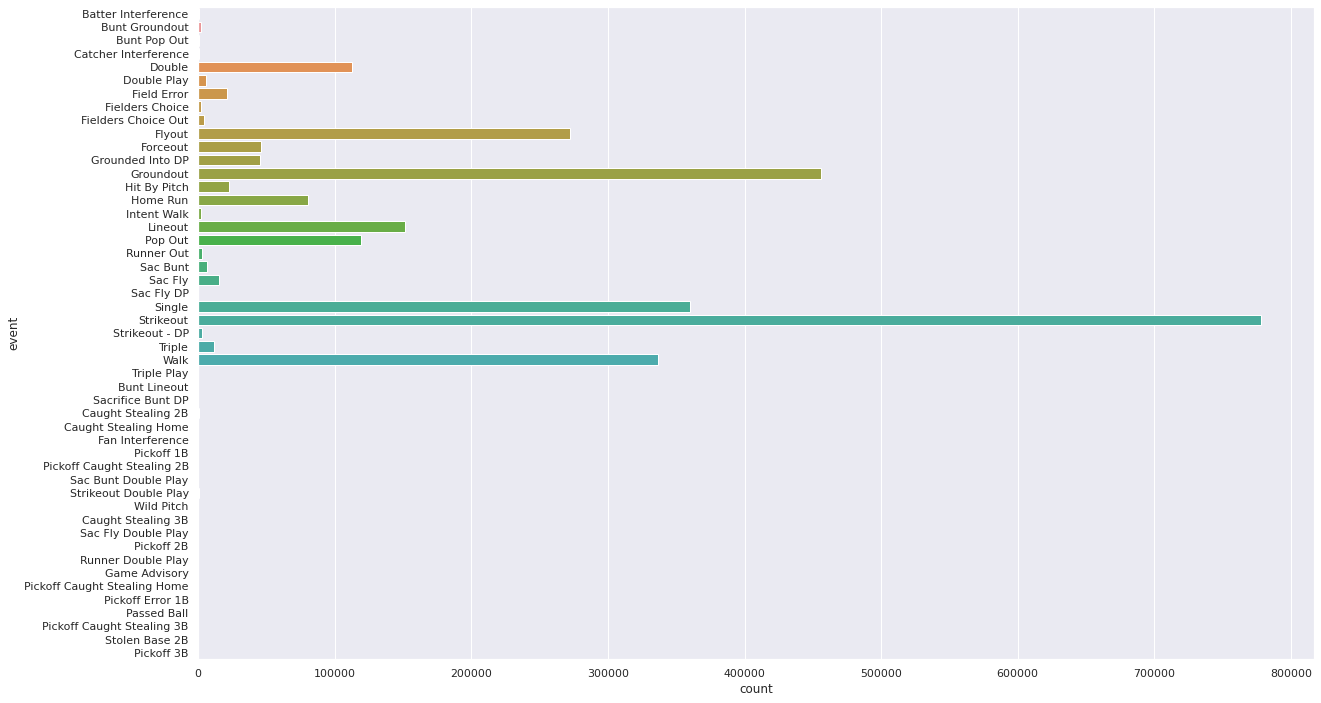

In [5]:
# Target variable: Graph the frequency of outcomes
sns.set_theme(context="notebook", style="darkgrid", palette="gist_ncar_r")

# Events
fig = plt.figure(figsize=(20,12))
sns.countplot(y="event", data=df_main, orient="h")
plt.xscale("linear")
plt.show()
fig.savefig("figures/events-countplot.png")

In [6]:
# Sort Events by Occurences
df_main.groupby("event").event.count().sort_values(ascending=False)

event
Strikeout                       778181
Groundout                       455963
Single                          360114
Walk                            336358
Flyout                          272196
Lineout                         151690
Pop Out                         119214
Double                          112379
Home Run                         80754
Forceout                         45984
Grounded Into DP                 44941
Hit By Pitch                     22669
Field Error                      21126
Sac Fly                          15149
Triple                           11378
Sac Bunt                          6735
Double Play                       5716
Fielders Choice Out               3883
Runner Out                        3141
Strikeout - DP                    2774
Fielders Choice                   2274
Intent Walk                       2009
Bunt Groundout                    1929
Strikeout Double Play              910
Bunt Pop Out                       899
Catcher Interferenc

### Mapped data: Lumping similar together
It is pretty clear that strikeout leads the way followed by ground, single, and walk. However, we can use our baseball knowledge to better make sense of which catrgories are similar. Since some events are relatively low, we will combine them together to increase the likelihood that our model can predict the "lumped" together `event`. 

Thus, combining the data above and knowledge of baseball, we get the following six outcomes for our target variable
- Non-HR Hit <- Single, Double, Triple
- HR < - Home Run
- Defensive Out <- Groundout, Flyout, Lineout, Pop Out, Forceout, Grounded Into DP, Double Play, Bunt Groundout, Fielders Choice, Fielders Choice Out, Bunt Lineout, Bunt Pop Out, Triple Play
- Strikeout <- Strikeout, Strikeout Double Play
- Walk <- Walk, Hit by Pitch, Intent Walk
- Sacrifice <- Sac Fly, Sac Bunt, Sac Fly Double Play, Sac Bunt Double Play
- Other <- Field Error, Catcher Interference, Batter Interference, Fan Interference

Sacrifice plays are an interesting subcategory because the rely on the presence and location of baserunners, the score of the game, and the prowress of the batter. Sacrifice events ($n = 5208$) such as:
- Sac Fly
- Sac Bunt
- Sac Fly Double Play
- Sac Bunt Double Play

will be scruitinzed carefully due to the fact these are not registered statistically as at bats. Furthermore, it will be intriguing to see how `pitch_type`, a charactristic of the pitcher, will relate to this play that is largely guided by factors external to the pitchers decision to throw a a specific pitch.

Similarly, plays that do not require the interaction between the pitcher and the batter are also dropped. For example, the [pickoff play](https://en.wikipedia.org/wiki/Pickoff) involves the pitcher throwing to a fellow defensive player to get an out. This does not require the interaction between the pitcher and the batter. Therefore the following inter-pitch events ($n = 801$) are also dropped: 
- Caught Stealing 2B
- Pickoff Caught Stealing 2B
- Pickoff 1B
- Caught Stealing Home
- Caught Stealing 3B
- Pickoff 2B
- Pickoff Caught Stealing Home
- Wild Pitch
- Pickoff 3B
- Pickoff Caught Stealing 3B
- Passed Ball
- Pickoff Error 1B
- Stolen Base 2B
- Runner Double Play
- Runner Out



In [7]:
# Create new dataframe "df_prepped"
df_prepped = df_main.reset_index(drop=True)

# List of non-at bat events
non_at_bat_subs_lst = \
["Caught Stealing 2B", "Pickoff Caught Stealing 2B", "Pickoff 1B", 
 "Caught Stealing Home", "Caught Stealing 3B", "Pickoff 2B", 
 "Pickoff Caught Stealing Home", "Wild Pitch", "Pickoff 3B", 
 "Pickoff Caught Stealing 3B", "Passed Ball", "Pickoff Error 1B", 
 "Stolen Base 2B", "Runner Double Play", "Runner Out"]

# Drop non-at bat events
mask = df_prepped.event.isin(non_at_bat_subs_lst)
df_prepped.event.iloc[mask] = np.nan
df_prepped = df_prepped[df_prepped["event"].notna()]

# Preview the loss of rows
df_prepped.shape

(2856943, 25)

Roughly 901 rows (0.13 %) were dropped when the non-at bat scenarios were removed from the dataset. These seem a little low because Bill James [reports](https://www.billjamesonline.com/legally_stolen_bases/#:~:text=The%202019%20Philadelphia%20Phillies%20allowed%2066%20stolen%20bases%2C,is%20the%20starting%20point%20of%20our%20process%20here.) that the Philadelphia Phillies caught 50 runners stealing bases in 2019. Expanded to all 30 teams that would mean 1500 runners were caught stealing, which almost doubles the amount here. Finding caught stealing stats proves to be difficult.

In [8]:
# Organize the subevents into lists
## Non-Hit HR
non_hit_HR_subs_lst = ["Single", "Double", "Triple"]
## HR
HR_subs_lst = ["Home Run"]
## Defensive Out
defensive_out_subs_lst =\
 ["Groundout", "Flyout", "Lineout", "Pop Out",  "Forceout", "Grounded Into DP", 
  "Double Play","Bunt Groundout", "Fielders Choice", "Fielders Choice Out", 
  "Bunt Lineout", "Bunt Pop Out", "Triple Play"]
## Strikeout
strikeout_subs_lst = ["Strikeout", "Strikeout Double Play"]
## Walk
walk_subs_lst = ["Walk", "Hit By Pitch", "Intent Walk"]
## Sacrifice
sac_subs_lst = ["Sac Fly", "Sac Bunt", 
                "Sac Fly Double Play", "Sac Bunt Double Play"]
## Other
other_subs_lst = ["Field Error", "Catcher Interference", "Batter Interference",
                  "Fan Interference"]
# Create empty series for updated events
event_new = pd.Series(index=range(len(df_main)))

# Map subcategories of event
relev_events = ["Non-HR Hit", "HR", "Def Out", "Strikeout", "Walk", "Sacrifice",
                "Other"]

# Use boolean masks to map the data accordingly
## Non-Hit HR
mask = df_main.event.isin(non_hit_HR_subs_lst)
event_new.iloc[mask] = relev_events[0]
## HR
mask = df_main.event.isin(HR_subs_lst)
event_new.iloc[mask] = relev_events[1]
## Defensive Out
mask = df_main.event.isin(defensive_out_subs_lst)
event_new.iloc[mask] = relev_events[2]
## Strikeout
mask = df_main.event.isin(strikeout_subs_lst)
event_new.iloc[mask] = relev_events[3]
## Walk
mask = df_main.event.isin(walk_subs_lst)
event_new.iloc[mask] = relev_events[4]
## Sacrifice
mask = df_main.event.isin(sac_subs_lst)
event_new.iloc[mask] = relev_events[5]
## Other
mask = df_main.event.isin(other_subs_lst)
event_new.iloc[mask] = relev_events[-1]

# Add event_new to dataframe 
df_prepped.insert(0, "event_new", event_new)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


From a previous iteration of the ML model, we know that `code` is an unfair feature to use because it effectively records what happens after the pitch is thrown. Since the objective is predict what pitches and scenarios lead to the various events, `code` is dropped from the dataframe.

In [9]:
# Drop "code"
df_prepped = df_prepped.drop(axis=1, columns=["code"])

# Also, drop the un-lumped "event", "first_name", "last_name", "pitcher_id", 
# and "ab_id" columns. "event_new" will be the new target variable and "ab_id"
# is not useful 
df_prepped = df_prepped.drop(axis=1, columns=["event", "pitcher_id", "ab_id", 
                                              "first_name", "last_name"])

In [10]:
df_prepped.head()

,event_new,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,pitch_type,b_score,b_count,s_count,outs,pitch_num,inning,p_score,p_throws,break_y,speed_diff,located_strike,location_call
0,Def Out,96.099998,87.699997,2564.835,238.878,43.099998,5.9,SI,0.0,0,0,0,1,1,0,R,NaN,NaN,1,strike
1,Def Out,81.900002,75.800003,1210.643,56.558,-13.200000,10.7,KC,0.0,0,1,0,2,1,0,R,NaN,NaN,1,strike
2,Def Out,96.199997,88.000000,2765.216,233.837,46.200001,5.3,SI,0.0,0,2,0,3,1,0,R,NaN,NaN,0,ball
3,Def Out,95.900002,88.199997,2727.998,242.226,45.700001,6.0,SI,0.0,1,2,0,4,1,0,R,NaN,NaN,0,ball
4,Def Out,83.400002,76.199997,1055.504,69.753,-13.900000,9.9,KC,0.0,2,2,0,5,1,0,R,NaN,NaN,1,strike


In [11]:
relev_event_new = ["Def Out", "HR", "Non-HR Hit", "Walk", "Sacrifice", 
                   "Strikeout", "Other"]

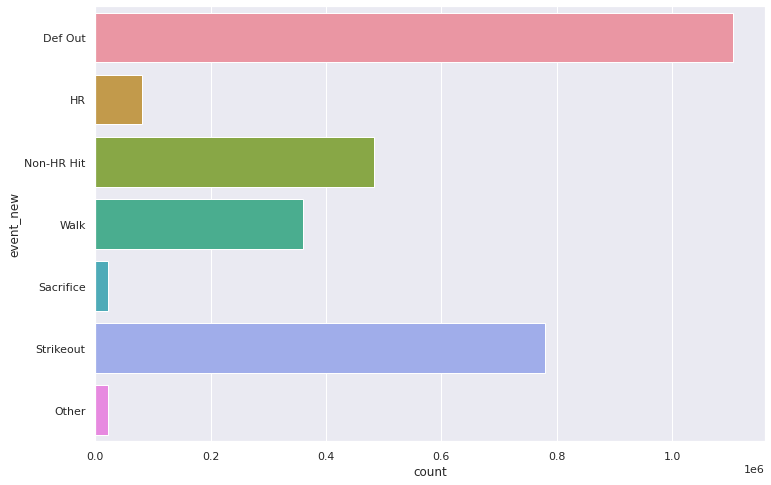

In [12]:
# Visualize lumped events
fig = plt.figure(figsize=(12,8))
sns.countplot(y="event_new", order=relev_event_new, data=df_prepped, orient="h")
plt.xscale("linear")
plt.show()
fig.savefig("figures/lumped_events.png", dpi=300)

## Model with sklearn

### Feature Engineering
Build features to help model with predictions. Please read the accompanying EDA notebook and post to see the other features that have been engineered for this project.

In [13]:
# Create a feature score_delta that relates the score of the game relative 
# to pitcher
df_prepped["score_delta"] = df_prepped.p_score - df_prepped.b_score

In [14]:
# Preview datatype
df_prepped.dtypes

event_new           object
start_speed        float32
end_speed          float32
spin_rate          float64
spin_dir           float64
break_angle        float32
break_length       float32
pitch_type        category
b_score            float64
b_count              int64
s_count              int64
outs                 int64
pitch_num            int64
inning               int64
p_score              int64
p_throws            object
break_y            float64
speed_diff         float32
located_strike       int64
location_call       object
score_delta        float64
dtype: object

### Impute missing values
For many of the models to be able to run, we will need to find if how many and where missing values may reside. To do this, the `msno` mask plot is used below. 

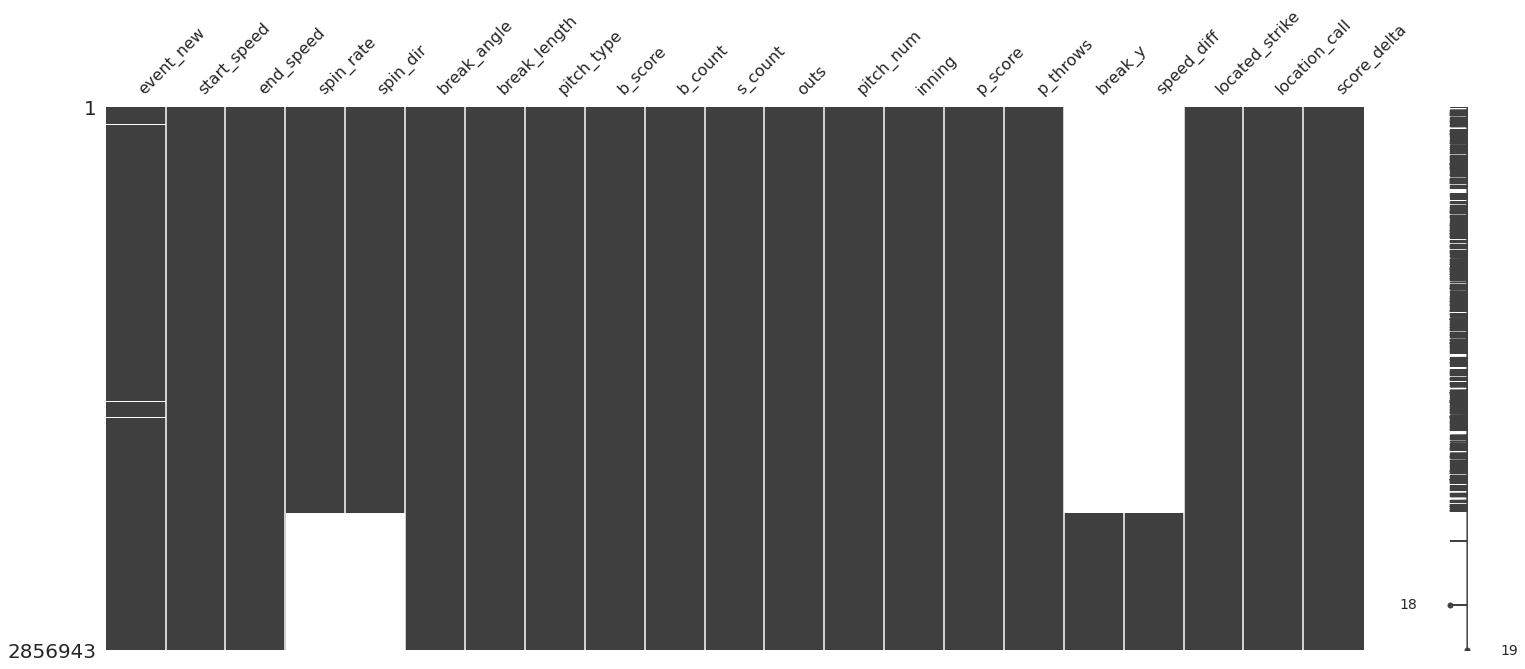

In [15]:
import missingno as msno
%matplotlib inline
msno.matrix(df_prepped)

From the plot above, the columns containing many >50 missing values are: `spin_dir`, `spin_rate`, `speed_diff`, and `break_y`.  Therefore, we will need to impute the missing values by entering the median value for all missing values. 

_Note: a simple imputer has been commented out because of the length of time that was required to run. Instead, the median value was used in columns where 50% or more was present. If a column did not meet that requirement, then it was dropped_

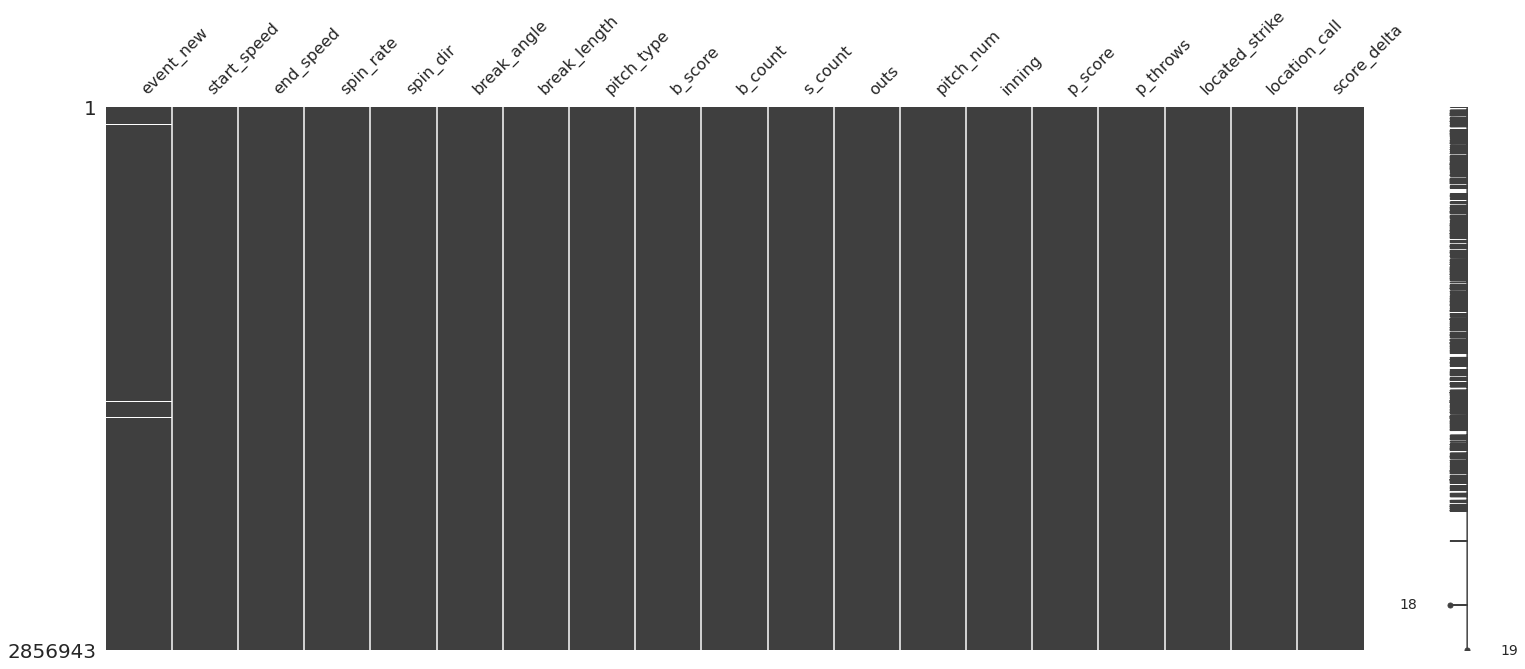

In [16]:
'''
from sklearn.impute import SimpleImputer
imp_median = SimpleImputer(strategy="most_frequent")
df_prepped = imp_median.fit_transform(df_prepped.iloc[:,1:])

# Export to csv
df_prepped.to_csv("df_prepped.csv", sep=",", index=False)
'''

# Find the values that will be imputed for the missing variables - the median 
# will be placed here
vals  = {"spin_rate":np.nanmedian(df_prepped.spin_rate), 
         "spin_dir":np.nanmedian(df_prepped.spin_dir)}
df_prepped.fillna(value=vals, inplace=True)
# Drop excess columns that have more than 50% rows missing
df_prepped.drop(columns=["break_y", "speed_diff"], axis=1, inplace=True)
# Plot data after alterations
msno.matrix(df_prepped)

Drop the small number of rows with NaN in the `event_new` column

In [17]:
df_prepped.dropna(subset=["event_new"], inplace=True)
df_prepped.reset_index(drop=True, inplace=True)

In [18]:
# Preview the dataframe and dimensions
df_prepped

,event_new,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,pitch_type,b_score,b_count,s_count,outs,pitch_num,inning,p_score,p_throws,located_strike,location_call,score_delta
0,Def Out,96.099998,87.699997,2564.835,238.878,43.099998,5.9,SI,0.0,0,0,0,1,1,0,R,1,strike,0.0
1,Def Out,81.900002,75.800003,1210.643,56.558,-13.200000,10.7,KC,0.0,0,1,0,2,1,0,R,1,strike,0.0
2,Def Out,96.199997,88.000000,2765.216,233.837,46.200001,5.3,SI,0.0,0,2,0,3,1,0,R,0,ball,0.0
3,Def Out,95.900002,88.199997,2727.998,242.226,45.700001,6.0,SI,0.0,1,2,0,4,1,0,R,0,ball,0.0
4,Def Out,83.400002,76.199997,1055.504,69.753,-13.900000,9.9,KC,0.0,2,2,0,5,1,0,R,1,strike,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853980,Def Out,95.800003,87.300003,1879.442,196.291,40.799999,3.6,FF,1.0,2,0,1,4,9,4,R,1,strike,3.0
2853981,Strikeout,87.199997,80.300003,1879.442,196.291,7.200000,7.2,SL,1.0,0,0,2,1,9,4,R,0,ball,3.0
2853982,Strikeout,95.000000,86.599998,1879.442,196.291,33.599998,3.6,FF,1.0,1,0,2,2,9,4,R,1,strike,3.0
2853983,Strikeout,84.000000,75.300003,1879.442,196.291,2.400000,8.4,SL,1.0,1,0,2,3,9,4,R,1,strike,3.0


### Encode categorical variables
There are several categorical variables in this dataset including the target variable, "event." For the ML algorithms to prcesss them appropriately, they need to be encoded as numeric values. Further guidance on incorporating categorical variables into ML models was gleaned from [Frank and Hall (2001)](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf) and [Chen et al.](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf)

Target Variable: `event_new`

To use `sklearn` we will need to apply an encoder to ensure that the target is recorded as numerical information instead of text

The `sklearn` [`label_encoder()`](https://sklearn.org/modules/generated/sklearn.preprocessing.LabelEncoder.html#:~:text=sklearn.preprocessing%20.LabelEncoder%20%C2%B6%20%20%20fit%20%28y%29%20,of%20this%20estimator.%20%201%20more%20rows%20) works well for this purpose. 

In [19]:
from sklearn.preprocessing import LabelEncoder
# Instantiate the encoder
target_encoder_le = LabelEncoder()

# Fit and transform the encoder to the target variable
## Separate target variable from explanatory features
y = df_prepped.iloc[:,0].values
## Apply encoder
y = target_encoder_le.fit_transform(y.astype(str))

Features: All variables that are not the target

Just like the target variable, the categorical variables from the explanatory data (i.e. features) will need to transformed with encoding.

In [20]:
# Instantiate the encoder
explanatory_encoder_le = LabelEncoder()

# Fit and transform the encoder to the explanatory variable
## Separate explanatory variables from the target variable
X = df_prepped.iloc[:, 1:].values

## Apply encoder
### pitch_type
X[:,6] = explanatory_encoder_le.fit_transform(X[:,6].astype(str))
### b_count
X[:,8] = explanatory_encoder_le.fit_transform(X[:,8].astype(str))
### s_count
X[:,9] = explanatory_encoder_le.fit_transform(X[:,9].astype(str))
### p_throws
X[:,14] = explanatory_encoder_le.fit_transform(X[:,14].astype(str))
### location_call
X[:,-2] = explanatory_encoder_le.fit_transform(X[:,-2].astype(str))

### Execute ML Algorithm(s)

- iteration 1.0.0: H2O only
- iteration 2.0.0: `RandomForestClassifier()` with max depth at 2 and seed at 42 (`code`) dropped as discussed with Josh (After 10 Jun 2021, this section was accidently overwritten with the entire data set)
- iteration 2.0.1: `RandomForestClassifier()` with same parameters as 2.0.0 but trained on the entire dataset of 2016-2019 with more engineered features (e.g., `speed_diff` and `location_call`). Moving forward, all iterations ≥ 2.0.1 and < 2.1.+ use this dataset.
- iteration 2.0.2: a `HistGradientClassifier()` is used on the dataset in a mo
- iteration 2.1.0: grid search across parameters for `RandomForestClassifier()`
- iteration 2.2.0: One-vs-Many SVM classifier

In [21]:
# Split dataframe into test and train sets
from sklearn.model_selection import train_test_split

# Train-test-split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)


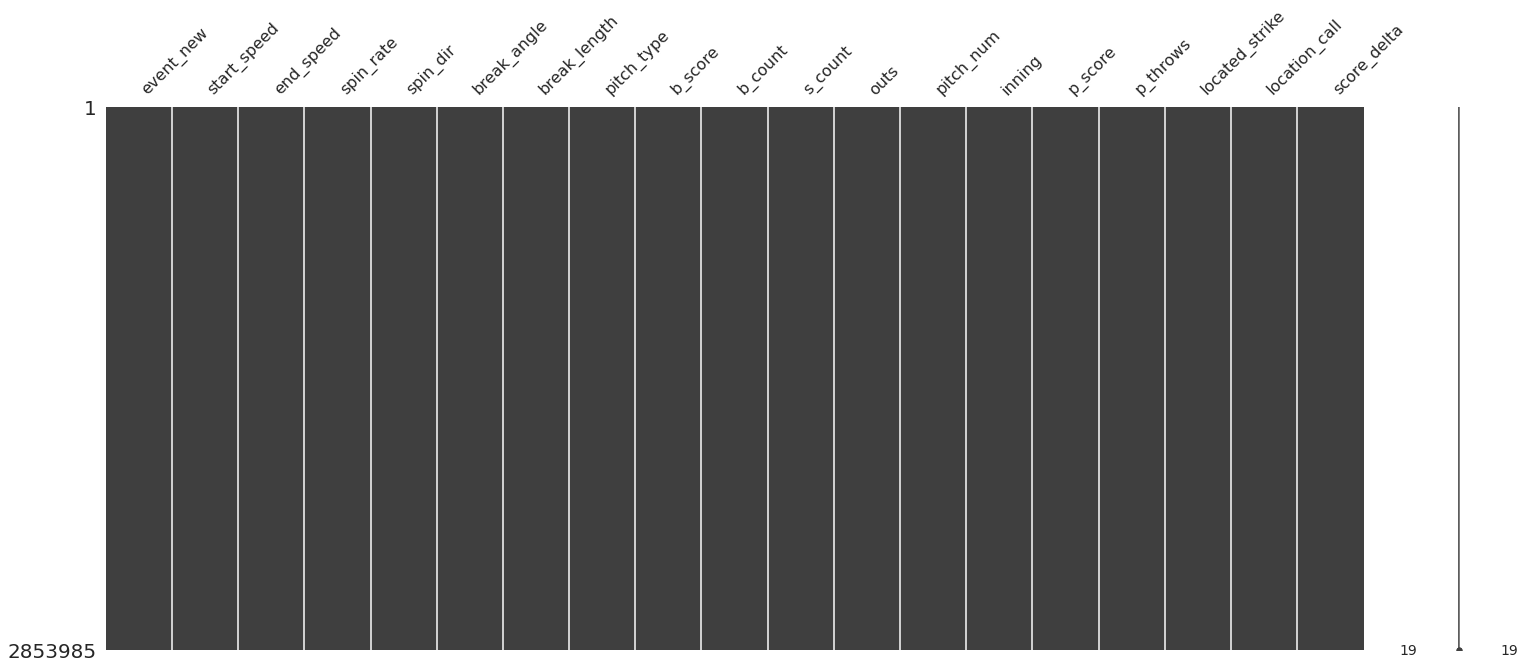

In [22]:
import missingno as msno
%matplotlib inline
msno.matrix(df_prepped)

#### Iteration 2.0.0

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Instantiate classifier
RF_clf = RandomForestClassifier(max_depth=2, random_state=42)
# Fit Classifier
RF_clf.fit(X_train, y_train)

# Best Fit for the Classifier (only added for consistency across iteration)
best_RF_clf = RF_clf

# Time to train: 5  min

Print Precision-Recall Table

In [ ]:
# Estimate perfromance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report as clf_report
# Predict with test data and best model
y_pred = best_RF_clf.predict(X_test)

# Print Report
mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
report_file = "RF_clf_iter-2.0.0.txt"
print(clf_report(y_test, y_pred, target_names=relev_event_new), 
      file=open(mdl_path+report_file, "w"))
# View the report in Colab
print(clf_report(y_test, y_pred, target_names=relev_event_new))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Def Out       0.39      1.00      0.56    220539
          HR       0.00      0.00      0.00     16370
  Non-HR Hit       0.00      0.00      0.00     97122
        Walk       0.00      0.00      0.00      4429
   Sacrifice       0.00      0.00      0.00      4478
   Strikeout       0.31      0.00      0.00    155299
       Other       0.00      0.00      0.00     72560

    accuracy                           0.39    570797
   macro avg       0.10      0.14      0.08    570797
weighted avg       0.23      0.39      0.22    570797



Visualize Results

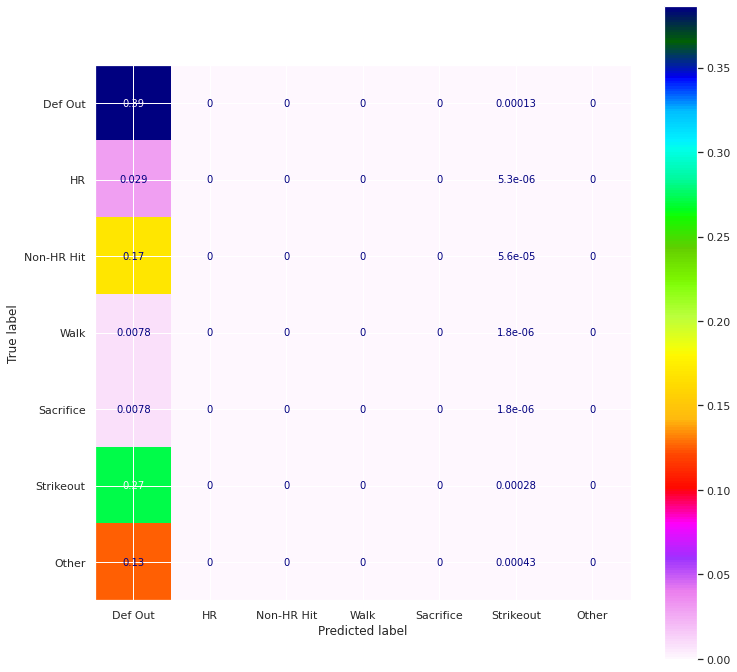

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(best_RF_clf, X_test, y_test,
                      cmap="gist_ncar_r",
                      display_labels=relev_event_new,
                      normalize="all",
                      ax=ax)
plt.show()
fig.savefig("figures/confusion_matrix_RF_iter-2.0.0.png", dpi=300)

Pickle RF model to be used later

In [ ]:
# Pickle the model for later
import pickle

# Path to save model
mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
# mdl file name
mdl_filename = "RF_clf_iter-2.0.0.pkl"

# Open a file to store model
outfile = open(mdl_path+mdl_filename, "wb")
# Open file to be pickled
pickle.dump(best_RF_clf, outfile)
# Close pickled model
outfile.close()

#### Iteration 2.0.1


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Instantiate classifier
RF_clf = RandomForestClassifier(max_depth=2, random_state=42)
# Fit Classifier
RF_clf.fit(X_train, y_train)

# Best Fit for the Classifier (only added for consistency across iteration)
best_RF_clf = RF_clf

# Time to train: <10 min

Print Precision-Recall Table

In [ ]:
# Estimate perfromance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report as clf_report
# Predict with test data and best model
y_pred = best_RF_clf.predict(X_test)

# Print Report
mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
report_file = "RF_clf_iter-2.0.1.txt"
print(clf_report(y_test, y_pred, target_names=relev_event_new), 
      file=open(mdl_path+report_file, "w"))
# View the report in Colab
print(clf_report(y_test, y_pred, target_names=relev_event_new))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Def Out       0.39      1.00      0.56    220539
          HR       0.00      0.00      0.00     16370
  Non-HR Hit       0.00      0.00      0.00     97122
        Walk       0.00      0.00      0.00      4429
   Sacrifice       0.00      0.00      0.00      4478
   Strikeout       0.31      0.00      0.00    155299
       Other       0.00      0.00      0.00     72560

    accuracy                           0.39    570797
   macro avg       0.10      0.14      0.08    570797
weighted avg       0.23      0.39      0.22    570797



Visualize Results

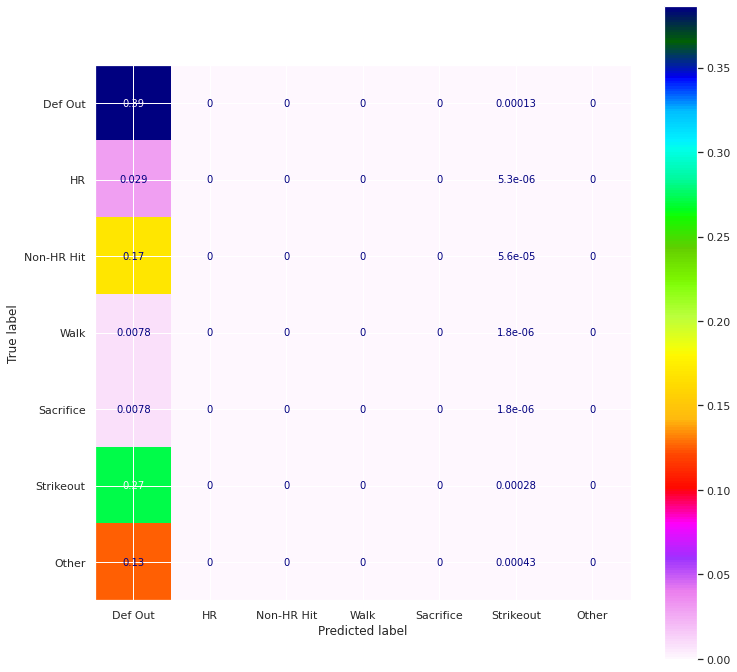

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(best_RF_clf, X_test, y_test,
                      cmap="gist_ncar_r",
                      display_labels=relev_event_new,
                      normalize="all",
                      ax=ax)
plt.show()
fig.savefig("figures/confusion_matrix_RF_iter-2.0.1.png", dpi=300)

Pickle RF model to be used later

In [ ]:
# Pickle the model for later
import pickle

# Path to save model
mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
# mdl file name
mdl_filename = "RF_clf_iter-2.0.1.pkl"

# Open a file to store model
outfile = open(mdl_path+mdl_filename, "wb")
# Open file to be pickled
pickle.dump(best_RF_clf, outfile)
# Close pickled model
outfile.close()

#### Iteration 2.0.2

This iteration uses the default parameters for a `HistGradientBoostingClassifier` except for a slightly higher learning rate of 0.25. 

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report as clf_report
from tqdm import tqdm
import random

# List possible scenarios
lr = [0.1, 0.25, 0.50]
l2 = [0, 1, 2]
mln = [21, 31, 41]

params = []

for i in tqdm(range(3)):
  print("Iteration Number: ", i)
  p = [np.random.choice(lr), 
       np.random.choice(l2), 
       np.random.choice(mln)]
  HGBC = HistGradientBoostingClassifier(loss="categorical_crossentropy",
                                        learning_rate=p[0],
                                        l2_regularization=p[1],
                                        max_leaf_nodes=p[2],
                                        verbose=2,
                                        random_state=0)
  params.append(p)
  print(p)
  HGBC.fit(X_train, y_train)
  y_pred = HGBC.predict(X_test)
  # Print Report
  mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
  report_file = "HGBC_iter-2.0.2.{}.txt".format(i)
  print(clf_report(y_test, y_pred, target_names=relev_event_new),
        file=open(mdl_path+report_file, "w"))
  print("The learning rate, l2 regualization strategy, and max leaf nodes are {}, respectively".format(p), file=open(mdl_path+report_file, "a"))
  # View in colab
  print(clf_report(y_test, y_pred, target_names=relev_event_new))

  # Pickle the model for later
  import pickle

  # mdl file name
  mdl_filename = "HGBC_iter-2.0.2.{}.pkl".format(i)

  # Open a file to store model
  outfile = open(mdl_path+mdl_filename, "wb")
  # Open file to be pickled
  pickle.dump(HGBC, outfile)
  # Close pickled model
  outfile.close()

# Time to train: 10 min




  0%|          | 0/3 [00:00<?, ?it/s]

Iteration Number:  0
[0.25, 0, 41]
Binning 0.329 GB of training data: 1.645 s
Fitting gradient boosted rounds:
[1/100] 7 trees, 287 leaves (41 on avg), max depth = 12, in 3.437s
[2/100] 7 trees, 287 leaves (41 on avg), max depth = 15, in 3.399s
[3/100] 7 trees, 287 leaves (41 on avg), max depth = 18, in 3.319s
[4/100] 7 trees, 287 leaves (41 on avg), max depth = 13, in 3.266s
[5/100] 7 trees, 287 leaves (41 on avg), max depth = 14, in 3.302s
[6/100] 7 trees, 287 leaves (41 on avg), max depth = 13, in 3.194s
[7/100] 7 trees, 287 leaves (41 on avg), max depth = 14, in 2.992s
[8/100] 7 trees, 287 leaves (41 on avg), max depth = 13, in 3.008s
[9/100] 7 trees, 287 leaves (41 on avg), max depth = 13, in 3.007s
[10/100] 7 trees, 287 leaves (41 on avg), max depth = 14, in 2.812s
[11/100] 7 trees, 287 leaves (41 on avg), max depth = 14, in 2.681s
[12/100] 7 trees, 287 leaves (41 on avg), max depth = 16, in 2.694s
[13/100] 7 trees, 287 leaves (41 on avg), max depth = 14, in 2.477s
[14/100] 7 tre



 33%|███▎      | 1/3 [03:21<06:43, 201.96s/it]

              precision    recall  f1-score   support

     Def Out       0.42      0.80      0.55    220539
          HR       0.14      0.00      0.01     16370
  Non-HR Hit       0.37      0.00      0.00     97122
        Walk       0.02      0.00      0.01      4429
   Sacrifice       0.04      0.01      0.01      4478
   Strikeout       0.44      0.32      0.37    155299
       Other       0.51      0.27      0.35     72560

    accuracy                           0.43    570797
   macro avg       0.28      0.20      0.19    570797
weighted avg       0.41      0.43      0.36    570797

Iteration Number:  1
[0.25, 2, 21]
Binning 0.329 GB of training data: 1.547 s
Fitting gradient boosted rounds:
[1/100] 7 trees, 147 leaves (21 on avg), max depth = 8, in 2.804s
[2/100] 7 trees, 147 leaves (21 on avg), max depth = 11, in 2.770s
[3/100] 7 trees, 147 leaves (21 on avg), max depth = 9, in 2.710s
[4/100] 7 trees, 147 leaves (21 on avg), max depth = 12, in 2.661s
[5/100] 7 trees, 147 leave



 67%|██████▋   | 2/3 [06:34<03:19, 199.11s/it]

              precision    recall  f1-score   support

     Def Out       0.42      0.80      0.55    220539
          HR       0.78      0.00      0.00     16370
  Non-HR Hit       0.44      0.00      0.00     97122
        Walk       0.00      0.00      0.00      4429
   Sacrifice       0.67      0.00      0.00      4478
   Strikeout       0.44      0.33      0.37    155299
       Other       0.51      0.27      0.35     72560

    accuracy                           0.43    570797
   macro avg       0.46      0.20      0.18    570797
weighted avg       0.45      0.43      0.36    570797

Iteration Number:  2
[0.5, 2, 21]
Binning 0.329 GB of training data: 1.571 s
Fitting gradient boosted rounds:
[1/100] 7 trees, 147 leaves (21 on avg), max depth = 8, in 2.812s
[2/100] 7 trees, 147 leaves (21 on avg), max depth = 10, in 2.658s
[3/100] 7 trees, 147 leaves (21 on avg), max depth = 10, in 2.713s
[4/100] 7 trees, 147 leaves (21 on avg), max depth = 11, in 2.550s
[5/100] 7 trees, 147 leave



100%|██████████| 3/3 [09:32<00:00, 190.90s/it]

              precision    recall  f1-score   support

     Def Out       0.42      0.79      0.55    220539
          HR       0.27      0.00      0.00     16370
  Non-HR Hit       0.33      0.00      0.01     97122
        Walk       0.18      0.00      0.00      4429
   Sacrifice       0.31      0.00      0.00      4478
   Strikeout       0.43      0.33      0.37    155299
       Other       0.50      0.27      0.35     72560

    accuracy                           0.43    570797
   macro avg       0.35      0.20      0.18    570797
weighted avg       0.41      0.43      0.36    570797



#### Iteration 2.0.3
AdaBoost `for` loop gridsearch. Base estimator is the same as in 2.0.1 (i.e., this is a boosted RF)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report as clf_report
from tqdm import tqdm

# Base estimator
RF_clf = RandomForestClassifier(max_depth=2, random_state=42)

n_est = [100,125,150]

for i in tqdm(range(len(n_est))):
  print(n_est[i])
  ABC = AdaBoostClassifier(base_estimator=RF_clf,
                           n_estimators=n_est[i],
                           random_state=0)
  ABC.fit(X_train, y_train)
  y_pred = ABC.predict(X_test)

   # Print Report
  mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
  report_file = "ABC_iter-2.0.3.{}.txt".format(i)
  print(clf_report(y_test, y_pred, target_names=relev_event_new),
        file=open(mdl_path+report_file, "w"))
  print("The number of estimators for this run of AdaBoostClassifier is {}"\
        .format(n_est[i]), 
        file=open(mdl_path+report_file, "a"))
  # View in colab
  print(clf_report(y_test, y_pred, target_names=relev_event_new))

  # Pickle the model for later
  import pickle

  # mdl file name
  mdl_filename = "ABC_iter-2.0.3.{}.pkl".format(i)

  # Open a file to store model
  outfile = open(mdl_path+mdl_filename, "wb")
  # Open file to be pickled
  pickle.dump(ABC, outfile)
  # Close pickled model
  outfile.close()


# Time to train: 




  0%|          | 0/3 [00:00<?, ?it/s]

100


#### Iteration 2.0.4
This iteration uses `XGBoost`

In [ ]:
import xgboost as xgb



#### Iteration 2.0.4

In this iteration, a function is defined to train the model used in 2.0.1 and 2.0.2; however, the function uses merges minority oversampling and statified K-folding. The parameters are chosen after conducting gridsearches in iterations ≥ 2.1.1.

In [ ]:
# Install imbalacned-learn
!pip install -U imbalanced-learn

     |████████████████████████████████| 215kB 4.3MB/s 
     |████████████████████████████████| 22.3MB 1.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report as clf_report

# Instantiate and create a list of models to be analyzed - parameters were chosen from the 
## Random Forest
RF_clf = RandomForestClassifier(n_estimators=150,
                                max_depth=30,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                verbose=2,
                                n_jobs=-1,
                                random_state=0)
## HistGradientBoostingClassifier
HGBC = HistGradientBoostingClassifier(verbose=2,
                                      random_state=0))

## AdaBoostClassifier
ABC = AdaBoostClassifier()

mdls = [RF_clf, HGBC, ABC] 

# Define function to oversample minority classes and then apply stratified K 
# folding followed by training and reporting the results
def smote_skf_trainer(X, y, mdl):
  # Acquire the counting stats for the distribution of classes
  n_per_class = pd.Series(index=range(len(np.unique(y))))
  for i in range(len(np.unique(y))):
    n_per_class[i] = np.count_nonzero(y == i)

  # Estalish the class with the highest number of occurences
  max_class = max_class = np.int_(np.max(n_per_class))

  # Instantiate a SMOTE object with specific percentages for the smallest the minority classes
  over = SMOTE(sampling_strategy={0:max_class,
                          1:round(max_class*0.15),
                          2:np.count_nonzero(y==2),
                          3:round(max_class*0.20),
                          4:round(max_class*0.075),
                          5:np.count_nonzero(y==5),
                          6:np.count_nonzero(y==6)},
               random_state=0)
  
  # Fit and resample using the SMOTE object
  X_resamp, y_resamp = over(X, y)

  # Instantiate the Stratified K-folding Object
  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

  # Split Resampled data into training and test data
  count = 0
  for train_idx, test_idx in skf.split(X_resamp, y_resamp):
    print("Loop Number: ", count)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit model to training data
    for m in mdl:
      print(mdl[m])
      mdl[m].fit(X_train, y_train)
      # Predict
       y_pred = mdl[m].predict(X_test)
      # Report
      print(clf_report(y_test, y_pred, target_names=relev_event_new))

    count = count + 1
    
  



#### Iteration 2.1.0

_params_
- n_estimators: [100, 125, 150]
- max_depth: [5, 15, 30]
- min_samples: [2, 3]
- min_samples_leaf: [1,2]
- random_state: 0

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score

# Create a pipeline for creating RF classifier
pipe = Pipeline([
                 ("scaler", StandardScaler()),
                 ("RF_clf", RandomForestClassifier())
])

# Establish parameter grid
params = {
    "RF_clf__n_estimators": [100,125,150],
    "RF_clf__max_depth": [5,15,30],
    "RF_clf__min_samples_split": [2, 3],
    "RF_clf__min_samples_leaf": [1,2],
    "RF_clf__random_state": [0],
    "RF_clf__verbose": [1],
}

# Grid Search and Fit
RF_clf_gs = GridSearchCV(pipe, param_grid=params, cv=3,
                         scoring="balanced_accuracy")
RF_clf_gs.fit(X_train, y_train)

# Get best estimator
best_RF_clf_gs = RF_clf_gs.best_estimator_


import pickle
# Path to save model
mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
# mdl file name
mdl_filename = "RF_clf_GridSearch_iter-2.1.0.pkl"

# Open a file to store model
outfile = open(mdl_path+mdl_filename, "wb")
# Pickle model
pickle.dump(best_RF_clf_gs, outfile)
# Close pickled model
outfile.close()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   29.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   29.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   28.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [ ]:
print("Best parameters: ", RF_clf_gs.best_params_)
print("Accuracy: ", RF_clf_gs.score(X_test, y_test))
print("CV results: ", RF_clf_gs.cv_results_)

Best parameters:  {'RF_clf__max_depth': 30, 'RF_clf__min_samples_leaf': 1, 'RF_clf__min_samples_split': 2, 'RF_clf__n_estimators': 150, 'RF_clf__random_state': 0, 'RF_clf__verbose': 1}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy:  0.19852340006615984
CV results:  {'mean_fit_time': array([ 30.11250257,  37.06872527,  44.47249889,  30.02428706,
        39.25519586,  45.82754246,  31.00300924,  38.82747944,
        46.57089504,  31.34472799,  38.57880123,  45.35176063,
        71.23172204,  91.94051313, 102.04829804,  68.00938106,
        86.3592306 ,  98.67675257,  65.49510495,  83.84445349,
       101.11582756,  71.11624257,  87.46442358, 108.22276092,
       115.75218527, 155.13003953, 178.38317124, 120.02377168,
       152.75961423, 177.09041731, 112.62495693, 140.23747484,
       172.60659575, 115.28358905, 146.80677541, 171.23084776]), 'std_fit_time': array([0.50417414, 0.55004806, 1.06424822, 0.38145401, 0.79027025,
       0.42603221, 0.25052103, 0.2357014 , 0.17957171, 0.99586644,
       0.68229719, 1.12562512, 0.7744828 , 1.05930079, 2.05556534,
       0.82233599, 2.19788552, 1.22698787, 0.77504351, 1.21782655,
       2.24314969, 1.78097458, 1.14992647, 3.3139969 , 1.58912705,
       8.22337053,

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   15.0s finished


In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report as clf_report
from sklearn.metrics import confusion_matrix
# Get best prediction from grid search
y_pred = RF_clf_gs.best_estimator_.predict(X_test)

# Print Report
print(clf_report(y_test, y_pred, target_names=relev_event_new))

# Plot
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(RF_clf, X_test, y_test,
                      cmap="gist_ncar_r",
                      display_labels=relev_event_new,
                      normalize="all",
                      ax=ax)
plt.show()
plt.savefig("figures/confusion_matrix_RF-iter_2.1.0.png", dpi=300)

In [ ]:
relev_event_new

['Def Out', 'HR', 'Non-HR Hit', 'Walk', 'Sacrifice', 'Strikeout', 'Other']

#### Iteration 2.1.1

Used complete dataset (16-19)

_params_
- n_estimators: [100, 125, 150]
- max_depth: [5, 15, 30]
- min_samples: [2, 3]
- min_samples_leaf: [1,2]
- random_state: 0

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score

# Create a pipeline for creating RF classifier
pipe = Pipeline([
                 ("scaler", StandardScaler()),
                 ("RF_clf", RandomForestClassifier())
])

# Establish parameter grid
params = {
    "RF_clf__n_estimators": [100,125,150],
    "RF_clf__max_depth": [5,15,30],
    "RF_clf__min_samples_split": [2, 3],
    "RF_clf__min_samples_leaf": [1,2],
    "RF_clf__random_state": [0],
    "RF_clf__verbose": [3],
}

# Grid Search and Fit
RF_clf_gs = GridSearchCV(pipe, param_grid=params, cv=3,
                         scoring="balanced_accuracy", 
                         n_jobs=-1, verbose=3)
RF_clf_gs.fit(X_train, y_train)

# Get best estimator
best_RF_clf_gs = RF_clf_gs.best_estimator_

# Time to train: 3+ hours

import pickle

# Path to save model
mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
# mdl file name
mdl_filename = "RF_clf_GridSearch_iter-2.1.1.pkl"

# Open a file to store model
outfile = open(mdl_path+mdl_filename, "wb")
# Pickle model
pickle.dump(best_RF_clf_gs, outfile)
# Close pickled model
outfile.close()

In [ ]:
print("Best parameters: ", RF_clf_gs.best_params_)
print("Accuracy: ", RF_clf_gs.score(X_test, y_test))
print("CV results: ", RF_clf_gs.cv_results_)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report as clf_report
from sklearn.metrics import confusion_matrix
# Get best prediction from grid search
y_pred = RF_clf_gs.best_estimator_.predict(X_test)

# Print Report
print(clf_report(y_test, y_pred, target_names=relev_event_new))

# Plot
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(RF_clf, X_test, y_test,
                      cmap="gist_ncar_r",
                      display_labels=relev_event_new,
                      normalize="all",
                      ax=ax)
plt.show()
plt.savefig("figures/confusion_matrix_RF-iter_2.1.1.png", dpi=300)

In [ ]:
# Split dataframe into test and train sets
from sklearn.model_selection import train_test_split

# Train-test-split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

#### Iteration 2.1.2
Gridsearch for `HistGradientBoostingClassifier`

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# Create a pipeline for creating RF classifier
pipe = Pipeline([
                 ("HGBC", HistGradientBoostingClassifier())
])

# Establish parameter grid
params = {
    "HGBC__loss": ["categorical_crossentropy"],
    "HGBC__learning_rate": [0.1, 0.25],
    "HGBC__max_iter": [50, 100, 175],
    "HGBC__max_leaf_nodes": [25, 31, 45],
    "HGBC__l2_regularization": [0, 1, 2],
    "HGBC__min_samples_leaf": [15, 20],
    "HGBC__random_state": [0],
    "HGBC__verbose": [3],
}

# Grid Search and Fit
HGBC_gs = GridSearchCV(pipe, param_grid=params,scoring="balanced_accuracy", 
                       n_jobs=31, verbose=3)
HGBC_gs.fit(X_train, y_train)

# Get best estimator
best_HGBC_gs = HGBC_gs.best_estimator_

# Time to train: 3+ hours

import pickle

# Path to save model
mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
# mdl file name
mdl_filename = "HGBC_GridSearch_iter-2.1.2.pkl"

# Open a file to store model
outfile = open(mdl_path+mdl_filename, "wb")
# Pickle model
pickle.dump(best_HGBC_gs, outfile)
# Close pickled model
outfile.close()

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
print("Best parameters: ", HGBC_gs.best_params_)
print("Accuracy: ", HGBC_gs.score(X_test, y_test))
print("CV results: ", HGBC_gs.cv_results_)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report as clf_report
from sklearn.metrics import confusion_matrix
# Get best prediction from grid search
y_pred = HGBC.best_estimator_.predict(X_test)

# Print Report
mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
report_file = "HGBC_gs_iter-2.1.2.txt"
print(clf_report(y_test, y_pred, target_names=relev_event_new), 
      file=open(mdl_path+report_file, "w"))
## View report on Colab
print(clf_report(y_test, y_pred, target_names=relev_event_new))

# Plot
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(HGBC, X_test, y_test,
                      cmap="gist_ncar_r",
                      display_labels=relev_event_new,
                      normalize="all",
                      ax=ax)
plt.show()
plt.savefig("figures/confusion_matrix_HGBC_gs-iter_2.1.2.png", dpi=300)

#### Iteration 2.2.0 / 2.2.1

Removing `StandardScaler()` from pipeline for RF classifier

*The same code use for 2.2.0 was used for 2.2.1; the difference is that the latter used the entire dataset, where 2.2.0 only used data from 2019.*

_params_
- n_estimators: [100, 125, 150]
- max_depth: [15, 30]
- min_samples: [2, 3]
- random_state: 0

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

# Create a pipeline for creating RF classifier
pipe = Pipeline([
                 ("RF_clf", RandomForestClassifier())
])

# Establish parameter grid
params = {
    "RF_clf__n_estimators": [100,125,150],
    "RF_clf__max_depth": [15,30],
    "RF_clf__min_samples_split": [2,3],
    "RF_clf__random_state": [0],
    "RF_clf__verbose": [1],
    "RF_clf__n_jobs": [-1]
}

# Stratified K Fold
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Grid Search and Fit
RF_clf_gs = GridSearchCV(pipe, param_grid=params, cv=skfold,
                         scoring="balanced_accuracy", 
                         verbose=2)

RF_clf_gs.fit(X_train, y_train)

# Get best estimator
best_RF_clf_gs = RF_clf_gs.best_estimator_

# Time to train: ≥ 4 hrs

import pickle

# Path to save model
mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
# best mdl file name
best_mdl_filename = "best__RF_clf_GridSearch_iter-2.2.1.pkl"
# mdl file name
mdl_filename = "RF_clf_GridSearch_iter-2.2.1.pkl"

# Open file to be pickled (best)
outfile_best = open(mdl_path+best_mdl_filename, "wb")
print("Opened file for best estimator")
# Open file to be pickled (all)
outfile_all = open(mdl_path+mdl_filename, "wb")
print("Opened file for all")
# Pickle model (best)
pickle.dump(RF_clf_gs, outfile_best)
# Pickle model (all)
pickle.dump(RF_clf_gs, outfile_all)
# Close pickled model
outfile_best.close()
print("Closed best file")
# Close pickled model
outfile_all.close()
print("Closed all file")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    8.0s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=100, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time= 9.0min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.5s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=100, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time= 8.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    9.1s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=100, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time= 8.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.9s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=100, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=12.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.5s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=100, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=12.6min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 13.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    9.3s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=125, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=13.4min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 12.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    9.3s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=125, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=12.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 12.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:   13.2s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=125, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=13.0min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 15.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    9.7s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=125, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=15.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 15.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    9.4s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=125, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=15.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   11.4s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=150, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=18.8min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 14.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   11.8s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=150, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=15.1min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 12.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   11.3s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=150, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=12.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 12.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   14.7s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=150, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=12.6min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   11.6s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=2, RF_clf__n_estimators=150, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=19.0min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.8s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=3, RF_clf__n_estimators=100, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=12.4min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.8s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=3, RF_clf__n_estimators=100, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=12.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.8s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=3, RF_clf__n_estimators=100, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=12.7min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.8s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=3, RF_clf__n_estimators=100, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=11.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.6s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=3, RF_clf__n_estimators=100, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=10.9min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 13.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    9.5s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=3, RF_clf__n_estimators=125, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=13.7min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 13.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    9.4s finished


[CV] END RF_clf__max_depth=15, RF_clf__min_samples_split=3, RF_clf__n_estimators=125, RF_clf__n_jobs=-1, RF_clf__random_state=0, RF_clf__verbose=1; total time=13.7min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.0min


In [ ]:
print("Best parameters: ", RF_clf_gs.best_params_)
print("Accuracy: ", RF_clf_gs.score(X_test, y_test))
print("CV results: ", RF_clf_gs.cv_results_)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report as clf_report
from sklearn.metrics import confusion_matrix
# Get best prediction from grid search
y_pred = RF_clf_gs.best_estimator_.predict(X_test)

# Print Report
print(clf_report(y_test, y_pred, target_names=relev_event_new))

# Plot
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(RF_clf, X_test, y_test,
                      cmap="gist_ncar_r",
                      display_labels=relev_event_new,
                      normalize="all",
                      ax=ax)
plt.show()
plt.savefig("figures/confusion_matrix_RF-iter_2.2.1.png", dpi=300)

#### Iteration 2.3.1

*note: 2.3.0 was run with just the 2019 data but was never pickled*

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import class_weight as cw
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions

# Calculate weight for each classes
y_unique = np.unique(y)
weights = cw.compute_class_weight("balanced", 
                                  y_unique,
                                  y)
# Create the linear SVM
svm_lin = SVC(kernel="rbf", 
              decision_function_shape="ovr",
              class_weight="balanced",
              random_state=0,
              verbose=True)

# Convert linear svm to One-vs-Many classifier
svm_OvR = OneVsRestClassifier(svm_lin)

# Fit OvR to data 
svm_OvR = svm_OvR.fit(X_train, y_train)

# Best Fit for the Classifier (only added for consistency across iteration)
best_svm_OvR = svm_OvR

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report as clf_report
from sklearn.metrics import confusion_matrix
# Get best prediction from grid search
y_pred = best_svm_OvR.predict(X_test)

# Print Report
print(clf_report(y_pred, y_test, target_names=relev_event_new))

# Evaluate fit
cm_matrix = plot_confusion_matrix(best_svm_OvR, X_test, y_test,
                                  cmap="gist_ncar_r",
                                  normalize="true")
plt.title('CM for OvR Classifier')
plt.show()
plt.savefig("figures/confusion_matrix_svm_OvR-iter_2.3.1.png", dpi=300)

# Plot decision boundary
plot_decision_regions(X_test, y_test, clf=best_svm_OvR)
plt.show()
plt.savefig("figures/decision_regions_svm_OvR-iter_2.3.1.png", dpi=300)

In [ ]:
import pickle

# Path to save model
mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
# mdl file name
mdl_filename = "svm_OvR_iter-2.3.1.pkl"

# Open file to be pickled
outfile = open(mdl_path+mdl_filename, "wb")
# Pickle model
pickle.dump(svm_OvR, outfile)
# Close pickled model
outfile.close()

#### Iteration 2.3.2

In [ ]:
# Convert linear svm to One-vs-Many classifier
svm_OvO = OneVsOneClassifier(svm_lin)

# Fit OvR to data 
svm_OvO = svm_OvO.fit(X_train, y_train)

In [ ]:
# Evaluate fit
cm_matrix = plot_confusion_matrix(svm_OvO, X_test, y_test,
                                  cmap="gist_ncar_r",
                                  normalize="true")
plt.title('CM for OvO Classifier')
plt.show(matrix)
plt.show()

# Plot decision boundary
plot_decision_regions(X_test, y_test, clf=svm_OvO)
plt.show()

#### Iteration 2.3.3
Balanced RF


In [ ]:
# Install imbalacned-learn
!pip install -U imbalanced-learn

     |████████████████████████████████| 215kB 3.1MB/s 
     |████████████████████████████████| 22.3MB 1.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Instantiate BRF
BRF = BalancedRandomForestClassifier(max_depth=15, n_estimators=150, 
                                     min_samples_split=2,
                                     verbose=1, random_state=0,
                                     class_weight="balanced")

# Fit Model to Training
BRF.fit(X_train, y_train)

# Predict outcome
y_pred = BRF.predict(X_test)

In [ ]:
from imblearn.metrics import classification_report_imbalanced as clf_report

print(clf_report(y_test, y_pred))

#### Iteration 2.3.4
GridSearch of Hyperparameters of Imbalanced Random Forest

In [ ]:
# Install imbalacned-learn
!pip install -U imbalanced-learn

Get a smaller subset of the data (between 20-40%) for analysis to examine how well the algo works. Later, pursue with `RandomStratifiedKFold`

In [ ]:
# Subsample of big dataframe 
data_subsample = df_prepped.sample(frac=0.30,random_state=0)

from sklearn.preprocessing import LabelEncoder
# Instantiate the encoder
target_encoder_le = LabelEncoder()

# Fit and transform the encoder to the target variable
## Separate target variable from explanatory features
y = data_subsample.iloc[:,0].values
## Apply encoder
y = target_encoder_le.fit_transform(y.astype(str))

In [ ]:
# Instantiate the encoder
explanatory_encoder_le = LabelEncoder()

# Fit and transform the encoder to the explanatory variable
## Separate explanatory variables from the target variable
X = data_subsample.iloc[:, 1:].values

## Apply encoder
### pitch_type
X[:,6] = explanatory_encoder_le.fit_transform(X[:,6].astype(str))
### b_count
X[:,8] = explanatory_encoder_le.fit_transform(X[:,8].astype(str))
### s_count
X[:,9] = explanatory_encoder_le.fit_transform(X[:,9].astype(str))
### p_throws
X[:,14] = explanatory_encoder_le.fit_transform(X[:,14].astype(str))
### location_call
X[:,-2] = explanatory_encoder_le.fit_transform(X[:,-2].astype(str))

In [ ]:
# Split dataframe into test and train sets
from sklearn.model_selection import train_test_split

# Train-test-split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

In [ ]:
e = data_subsample.event_new.astype("category")
fig = plt.figure(figsize=(8,6))
sns.countplot(y=e, orient="h")
fig.savefig("figures/lumped_events_subsample_2019.png", dpi=300)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

class Multiple_Clf_GridSearcher:
  # Define the initial call function 
  def __init__(self, models, params, 
               minority_sampling, minority_sampling_params):
    self.models = models
    self.params = params
    self.models_keys = models.keys()
    self.mss = minority_sampling
    self.mss_params = minority_sampling_params
    self.mss_keys = minority_sampling_params.keys()
    self.grid_searches = {}


  # Define the fitting function to train the models
  def fit(self, X, y, **grid_kwargs):
    for (key_mdl, key_mss) in zip(self.models_keys, self.mss_keys):
      print("Applying SMOTE for imblanced classes ...")
      print(self.models[key_mdl])
      print(self.mss_params[key_mss])
      over = SMOTE(sampling_strategy= self.mss_params[key_mss])
      X_resamp, y_resamp = over.fit_resample(X, y)
      print("Running GridSearchCV for %s ..." % key_mdl)
      model = self.models[key_mdl]
      params= self.params[key_mdl]
      grid_search = GridSearchCV(model, params, **grid_kwargs)
      grid_search.fit(X_resamp,y_resamp)
      self.grid_searches[key_mdl] = grid_search
      print("... Round of fitting complete")
    print("Done")

  # Create a dataframe of the results
  def score_summary(self, sort_by= "mean_test_score"):
    frames = []
    for name, grid_search in self.grid_searches.items():
      frame = pd.DataFrame(grid_search.cv_results_)
      frame = frame.filter(regex='^(?!.*param_).*$')
      frame['estimator'] = len(frame)*[name]
      frames.append(frame)

    df = pd.concat(frames)
    df = df.sort_values([sort_by], ascending=False)
    df = df.drop(["rank_test_score", "index"], 1)

    cols = df.columns.tolist()
    cols.remove("estimator")
    cols = ["estimator"] + cols
    
    df = df[cols]

    return df

In [ ]:
# Grid Search
f1_samples = make_scorer(f1_score, average="weighted")

mdls = {
    "RandomForestClassifier": RandomForestClassifier(),
    "GBC": GradientBoostingClassifier()
}

param_grid = {
    # Random Forest
    "RandomForestClassifier": [
                               {
                                "n_estimators":[125,150],
                                "max_depth":[5,10],
                                "min_samples_split":[2,3],
                                "random_state":[0],
                                "verbose":[True]
                               }
    ],
    # Gradient Boost
    "GradientBoostingClassifier":[
                                  {
                                   "loss":["deviance","exponential"],
                                   "learning_rate":[0.1, 1.0],
                                   "n_estimators":[100, 150, 175],
                                   "min_samples_split":[3,5],
                                   "max_depth":[3,5],
                                   "random_state":[0],
                                   "max_features":["auto"],
                                   "verbose":[2]
                                  }
    ]
}

# Establish the count for the number of occurences for each class
n_per_class = pd.Series(index=range(len(np.unique(y_train))))
for i in range(len(np.unique(y_train))):
  n_per_class[i] = np.count_nonzero(y_train == i)

# Estalish the class with the highest number of occurences
max_class = max_class = np.int_(np.max(n_per_class))

minority_sampling = {
    "sampling_strategy":"sampling_strategy",
    "random_state":"random_state"
}

minority_sampling_params = {
    "sampling_strategy_1":
                           {0:max_class,
                            1:round(max_class*0.15),
                            2:np.count_nonzero(y_train==2),
                            3:round(max_class*0.20),
                            4:round(max_class*0.075),
                            5:np.count_nonzero(y_train==5),
                            6:np.count_nonzero(y_train==6)},
    "sampling_strategy_2":
                           {0:max_class,
                            1:round(max_class*0.25),
                            2:np.count_nonzero(y_train==2),
                            3:round(max_class*0.15),
                            4:round(max_class*0.15),
                            5:np.count_nonzero(y_train==5),
                            6:np.count_nonzero(y_train==6)},
    "random_state":[
                    {0}
                    ]
}

gsearch = Multiple_Clf_GridSearcher(mdls, param_grid,
                                    minority_sampling, minority_sampling_params)
gsearch.fit(X_train, y_train, scoring=f1_samples, n_jobs=-1, verbose=2)
gsearch.score_summary()

NameError: ignored

[Pickle](https://medium.com/@maziarizadi/pickle-your-model-in-python-2bbe7dba2bbb) (a.k.a serialize) the model so that it can be accessed without having to retrain the model. 

In [ ]:
import pickle
# Path to save model
mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
mdl_filename = "grid-searched-multi_classifier_iter-2.3.4.pkl"
pickle.dump(gsearch, open(mdl_path+mdl_filename,"wb"))

Plot an example of the difference between the subsampled target labels in `y_train` and the minority sampled labels using `SMOTE()`. 

In [ ]:
over = SMOTE(sampling_strategy={0:max_class,
                          1:round(max_class*0.15),
                          2:np.count_nonzero(y_train==2),
                          3:round(max_class*0.20),
                          4:round(max_class*0.075),
                          5:np.count_nonzero(y_train==5),
                          6:np.count_nonzero(y_train==6)}, random_state=0)
xx,yy = over.fit_resample(X_train,y_train)

# Count Plot of Subsampled Events
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(y)
ax.set_xticklabels(relev_events)
plt.show()
fig.savefig("figures/countplot_subsampled_events.png", dpi=300)
# Minority Sampled Subsampled Events
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(yy)
ax.set_xticklabels(relev_events)
plt.show()
fig.savefig("figures/countplot_subsampled_minority_sampled_events.png", dpi=300)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix as ml_cm
from sklearn.metrics import classification_report as clf_report

# Get Best Model
best_gsearch_clf = gsearch.best_estimator_

# Predict with test data and best model
y_pred = best_gsearch_clf.predict(X_test)

# Print Report
print(clf_report(y_pred, y_test))

In [ ]:
# Create steps for pipeline
## Random Forest 
RF_clf = RandomForestClassifier()
## SVM - OneVsRest
svm_OvR = SVC()    
## Minority class over sampling (makes up for imbalance)
over = SMOTE()
## Steps for pipeline
steps = [("sampling", over), ("clf", RF_clf)]

# Establish pipeline
pipeline = Pipeline(steps=steps)

# Establish the count for the number of occurences for each class
n_per_class = pd.Series(index=range(len(np.unique(y_train))))
for i in range(len(np.unique(y_train))):
  n_per_class[i] = np.count_nonzero(y_train == i)

# Estalish the class with the highest number of occurences
max_class = max_class = np.int_(np.max(n_per_class))

# Establish parameters
## sampling strategy has to be done by inspecting the imblance of the classes manually
params = [
          {"sampling__random_state":[0],
           "sampling__sampling_strategy":[{0:max_class,
                                           1:round(max_class*0.15, 0),
                                           2:np.count_nonzero(y_train==2),
                                           3:round(max_class*0.20, 0),
                                           4:round(max_class*0.075, 0),
                                           5:np.count_nonzero(y_train==5),
                                           6:np.count_nonzero(y_train==6)},
                                          
                                          {0:max_class,
                                           1:round(max_class*0.25, 0),
                                           2:np.count_nonzero(y_train==2),
                                           3:round(max_class*0.15, 0),
                                           4:round(max_class*0.15, 0),
                                           5:np.count_nonzero(y_train==5),
                                           6:np.count_nonzero(y_train==6)}
                                          ]},
          
          # Random Forest Classifier
          {"clf":[RF_clf],
           "clf__n_estimators": [125,150],
           "clf__max_depth": [5,10],
           "clf__min_samples_split": [2, 3],
           "clf__min_samples_leaf": [1],
           "clf__random_state": [0],
           "clf__verbose": [True]},
          # SVM - OneVsRest Classifier
          {"clf":[svm_OvR],
           "clf__C":[1, 10],
           "clf__random_state":[0],
           "clf__kernel":["rbf", "poly"],
           "clf__decision_function_shape":["ovr"],
           "clf__verbose":[True]}
          ]

# Grid Search
f1_samples = make_scorer(f1_score, average="weighted")
gridsearch = GridSearchCV(estimator=pipeline, param_grid=params,
                          cv=3, n_jobs=-1, 
                          scoring=f1_samples,
                          verbose=2)
# Train Model
gridsearch.fit(X_train, y_train)
# Get Best RF
best_RF_clf = gridsearch.best_estimator_
# Print Best parameters
print(gridsearch.best_params_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Fitting 3 folds for each of 14 candidates, totalling 42 fits


NotFittedError: ignored

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix as ml_cm
from sklearn.metrics import classification_report as clf_report

# Predict with test data and best model
y_pred = best_RF_clf.predict(X_test)

# Print Report
print(clf_report(y_test, y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

           0       0.55      0.41      0.47     18012
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.50      0.01         2
           4       0.18      0.02      0.03      2843
           5       0.41      0.40      0.40     10541
           6       0.31      0.32      0.31      4651

    accuracy                           0.37     36049
   macro avg       0.21      0.23      0.18     36049
weighted avg       0.45      0.37      0.40     36049



[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[[12043, 10540],
        [ 5994,  7472]],

       [[34950,     0],
        [ 1099,     0]],

       [[30043,     0],
        [ 6006,     0]],

       [[35776,     1],
        [  271,     1]],

       [[33003,  2798],
        [  203,    45]],

       [[19500,  6341],
        [ 6008,  4200]],

       [[28116,  3183],
        [ 3282,  1468]]])

#### Iteration 2.3.5
This iteration continues to tune hyperparameters by leveraging a bagging ensmble method. Through this method several base estimators are examined and the use of the `imblanced` api assists in over sampling the minority classes through this process. 

Using `BalancedBaggingClassifier()`. The documentation can be found [here](https://imbalanced-learn.org/dev/references/generated/imblearn.ensemble.BalancedBaggingClassifier.html).

In [ ]:
# Install imbalacned-learn
!pip install -U imbalanced-learn

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Establish base estimators
## RandomForestClassifier
RF_clf = RamdomForestClassifier()

# Establish the count for the number of occurences for each class
n_per_class = pd.Series(index=range(len(np.unique(y_train))))
for i in range(len(np.unique(y_train))):
  n_per_class[i] = np.count_nonzero(y_train == i)

# Estalish the class with the highest number of occurences
max_class = max_class = np.int_(np.max(n_per_class))

# Parameter Grid
params = {
 "bootstrap": [True, False],
 "bootstrap_features": [True, False],    
 "n_estimators": [100,125,150],
 "sampling_strategy":{0:max_class,
                      1:round(max_class*0.15),
                      2:np.count_nonzero(y_train==2),
                      3:round(max_class*0.20),
                      4:round(max_class*0.075),
                      5:np.count_nonzero(y_train==5),
                      6:np.count_nonzero(y_train==6)},
 'max_samples' : [0.8, 1.0, 1.5],
 "random_state":[0],
 "base_estimator__bootstrap": [True, False],    
 "base_estimator__n_estimators": [125,150],
 "base_estimator__max_depth": [5,15,30],
 "base_estimator__min_samples_split": [2,3],
 "base_estimator__min_samples_leaf": [1,2],
 "base_estimator__verbose":[2],
 "base_estimator__n_jobs":[-1],
}

# Run the gridsearch with a 3-fold cross-validation
bag_clf_gs = GridSearchCV(base_estimator=RF_clf, param_grid=params, cv=3,
                          verbose=3)


# Time to train: 

# Get Best RF frpm BaggingClassifier
best_bag_clf = bag_clf_gs.best_estimator_

import pickle

# Path to save model
mdl_path = "/content/gdrive/My Drive/Colab Notebooks/pitch-sequence/serialized-models/"
# best mdl file name
best_mdl_filename = "best__bag_clf_GridSearch_iter-2.3.5.pkl"
# mdl file name
mdl_filename = "bag_clf_GridSearch_iter-2.3.5.pkl"

# Open file to be pickled (best)
outfile_best = open(mdl_path+best_mdl_filename, "wb")
print("Opened file for best estimator")
# Open file to be pickled (all)
outfile_all = open(mdl_path+mdl_filename, "wb")
print("Opened file for all")
# Pickle model (best)
pickle.dump(RF_clf_gs, outfile_best)
# Pickle model (all)
pickle.dump(RF_clf_gs, outfile_all)
# Close pickled model
outfile_best.close()
print("Closed best file")
# Close pickled model
outfile_all.close()
print("Closed all file")

In [ ]:
print("Best parameters: ", bag_clf_gs.best_params_)
print("Accuracy: ", bag_clf_gs.score(X_test, y_test))
print("CV results: ", bag_clf_gs.cv_results_)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report as clf_report
from sklearn.metrics import confusion_matrix

# Get best prediction from grid search
y_pred = bag_clf_gs.best_estimator_.predict(X_test)

# Print Report
print(clf_report(y_test, y_pred, target_names=relev_event_new))

# Plot
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(bag_clf_gs, X_test, y_test,
                      cmap="gist_ncar_r",
                      display_labels=relev_event_new,
                      normalize="all",
                      ax=ax)
plt.show()
plt.savefig("figures/confusion_matrix_bag_clf_gs-iter_2.2.1.png", dpi=300)

### Examine Pickled Models


In [ ]:
import pickle

# Loading model to compare the results
model_210 = pickle.load(open("/content/gdrive/MyDrive/Colab Notebooks/pitch-sequence/serialized-models/RF_clf_GridSearch_iter-2.1.0.pkl",'rb'))

EOFError: ignored

In [ ]:
model_210

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Model with H$_2$O
As an alternative to sklearn, we can use H$_2$O api lirbary to conduct a similar model

Install H2O for modeling

In [ ]:
!pip install h2o

     |████████████████████████████████| 164.8MB 79kB/s 
  Created wheel for h2o: filename=h2o-3.32.1.2-py2.py3-none-any.whl size=164848811 sha256=b187e29e3d3ebbe5baaef50fb9f84a8ca55edd2418d341d54c43e1b8c76fee6a
  Stored in directory: /root/.cache/pip/wheels/37/b6/c7/c1cfdcd471d476b2b5129f4d27a0fd89043858ee74eda7ee7a
Successfully built h2o


In [ ]:
import h2o
from h2o.estimators import H2ORandomForestEstimator
# Instantiate h2o in workspace
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdelbw2ee
  JVM stdout: /tmp/tmpdelbw2ee/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdelbw2ee/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_unknownUser_jios4y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
feat_list = df_prepped.iloc[:,1:].columns.to_list()

In [ ]:
# Establish data to be modeled
data = h2o.import_file("df_prepped.csv")
# Target variable
response = "event_new"
# Features
data["score_delta"] = data["p_score"] - data["b_score"]
feats = feat_list+["score_delta"]

Parse progress: |█████████████████████████████████████████████████████████| 100%


Train-test-split the data into training and testing dataframes

In [ ]:
# Split data into train and testing
train, test = data.split_frame(ratios=[0.8])

Establish RF Classifier Model

On first attempt, this model took 41 min to run.

After running the model, save it to `model_path`. This will now be in the Colab folder under "mdl_event_edit"

In [ ]:
# Define model
model = H2ORandomForestEstimator(max_depth=5, nfolds=10, seed=42)

# Train model
model.train(x=feats, y=response, training_frame=train)
model_path = h2o.save_model(model=model, path="mdl_event_edit", force=True)

drf Model Build progress: |███████████████████████████████████████████████| 100%


Examine Performance


In [ ]:
# Model performance
performance = model.model_performance(test_data=test)

print(performance)


ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.5244604220836859
RMSE: 0.7241963974528498
LogLoss: 1.394454985480229
Mean Per-Class Error: 0.7945646081392163
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Def Out,HR,Non-HR Hit,Other,Strikeout,Walk,Error,Rate
0,45803.0,0.0,0.0,0.0,6887.0,1898.0,0.160933,"8,785 / 54,588"
1,3844.0,0.0,0.0,0.0,521.0,193.0,1.000000,"4,558 / 4,558"
2,19864.0,0.0,0.0,0.0,2926.0,790.0,1.000000,"23,580 / 23,580"
3,846.0,0.0,0.0,0.0,147.0,47.0,1.000000,"1,040 / 1,040"
4,29884.0,0.0,0.0,0.0,9413.0,1261.0,0.767913,"31,145 / 40,558"
5,13050.0,0.0,0.0,0.0,2619.0,3017.0,0.838542,"15,669 / 18,686"
6,113291.0,0.0,0.0,0.0,22513.0,7206.0,0.592805,"84,777 / 143,010"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.407195
1,2,0.678750
2,3,0.859206
3,4,0.960863
4,5,0.992749
5,6,1.000000


Performance for each fold and a verbose summary of other metrics

In [ ]:
model.feature_frequencies

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1619944967047_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,300.0,135092.0,5.0,5.0,5.0,20.0,32.0,31.163334




ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.524773527673836
RMSE: 0.7244125396994698
LogLoss: 1.3947110793864854
Mean Per-Class Error: 0.7950591036828754
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Def Out,HR,Non-HR Hit,Other,Strikeout,Walk,Error,Rate
0,181947.0,0.0,0.0,0.0,27960.0,7415.0,0.162777,"35,375 / 217,322"
1,14897.0,5.0,0.0,0.0,2213.0,772.0,0.999720,"17,882 / 17,887"
2,79738.0,0.0,0.0,0.0,12040.0,3160.0,1.000000,"94,938 / 94,938"
3,3478.0,0.0,0.0,0.0,537.0,132.0,1.000000,"4,147 / 4,147"
4,120318.0,0.0,0.0,0.0,38752.0,5079.0,0.763922,"125,397 / 164,149"
5,52423.0,0.0,0.0,0.0,10289.0,11597.0,0.843935,"62,712 / 74,309"
6,452801.0,5.0,0.0,0.0,91791.0,28155.0,0.594413,"340,451 / 572,752"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.405587
1,2,0.679273
2,3,0.858061
3,4,0.961556
4,5,0.992765
5,6,1.000000



ModelMetricsMultinomial: drf
** Reported on cross-validation data. **

MSE: 0.524803709005949
RMSE: 0.72443337099139
LogLoss: 1.3945807271641213
Mean Per-Class Error: 0.7950512795795007
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Def Out,HR,Non-HR Hit,Other,Strikeout,Walk,Error,Rate
0,182700.0,1.0,1.0,0.0,27083.0,7537.0,0.159312,"34,622 / 217,322"
1,14940.0,1.0,0.0,0.0,2139.0,807.0,0.999944,"17,886 / 17,887"
2,80108.0,0.0,0.0,0.0,11614.0,3216.0,1.000000,"94,938 / 94,938"
3,3513.0,0.0,0.0,0.0,507.0,127.0,1.000000,"4,147 / 4,147"
4,121320.0,0.0,0.0,0.0,37724.0,5105.0,0.770184,"126,425 / 164,149"
5,52271.0,0.0,0.0,0.0,10213.0,11825.0,0.840867,"62,484 / 74,309"
6,454852.0,2.0,1.0,0.0,89280.0,28617.0,0.594502,"340,502 / 572,752"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.405498
1,2,0.678987
2,3,0.858344
3,4,0.961551
4,5,0.992760
5,6,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,accuracy,0.40549937,0.0021332395,0.40444803,0.40695015,0.4062817,0.40654254,0.40776378,0.40444994,0.40661338,0.40683225,0.40473238,0.40037966
1,auc,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aucpr,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,err,0.5945006,0.0021332395,0.59555197,0.5930499,0.5937183,0.59345746,0.5922362,0.59555006,0.5933866,0.5931678,0.59526765,0.59962034
4,err_count,34050.2,160.60774,34062.0,33961.0,33950.0,33852.0,34037.0,34181.0,33934.0,34033.0,34063.0,34429.0
5,logloss,1.3945813,0.0028661175,1.3929193,1.3880005,1.3961605,1.394834,1.3940411,1.3940126,1.3974584,1.3936613,1.3975782,1.3971469
6,max_per_class_error,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,mean_per_class_accuracy,0.20494916,5.5803626E-4,0.20446391,0.20446157,0.20448679,0.20578167,0.20554262,0.2045857,0.20538,0.20563065,0.20466521,0.20449351
8,mean_per_class_error,0.79505086,5.5803626E-4,0.7955361,0.7955384,0.7955132,0.79421836,0.7944574,0.79541427,0.79462004,0.79436934,0.79533476,0.7955065
9,mse,0.5248036,7.174183E-4,0.52465063,0.5232856,0.5249154,0.5244956,0.5244129,0.5249602,0.5253434,0.52456164,0.5255566,0.5258538



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-05-02 09:08:51,21 min 28.058 sec,0.0,NaN,NaN,NaN,NaN,NaN
1,,2021-05-02 09:08:53,21 min 29.802 sec,1.0,0.723530,1.397393,0.594036,NaN,NaN
2,,2021-05-02 09:08:55,21 min 31.578 sec,2.0,0.723196,1.396826,0.594018,NaN,NaN
3,,2021-05-02 09:09:00,21 min 37.531 sec,5.0,0.724132,1.397415,0.596225,NaN,NaN
4,,2021-05-02 09:09:05,21 min 41.808 sec,7.0,0.724052,1.396430,0.595684,NaN,NaN
5,,2021-05-02 09:09:09,21 min 46.124 sec,9.0,0.724083,1.395935,0.595656,NaN,NaN
6,,2021-05-02 09:09:13,21 min 50.420 sec,11.0,0.723992,1.395337,0.595687,NaN,NaN
7,,2021-05-02 09:09:17,21 min 54.538 sec,13.0,0.723730,1.394408,0.594813,NaN,NaN
8,,2021-05-02 09:09:22,21 min 59.343 sec,16.0,0.724024,1.394787,0.595323,NaN,NaN
9,,2021-05-02 09:09:26,22 min 3.468 sec,18.0,0.724119,1.394871,0.594985,NaN,NaN



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,b_count,128168.164062,1.000000,0.441139
1,pitch_num,87504.492188,0.682732,0.301180
2,s_count,41869.820312,0.326679,0.144111
3,pitch_type,15648.855469,0.122096,0.053861
4,start_speed,6553.925781,0.051135,0.022558
5,end_speed,3747.200928,0.029237,0.012897
6,inning,2438.934326,0.019029,0.008395
7,score_delta,1566.135498,0.012219,0.005390
8,b_score,1352.155518,0.010550,0.004654
9,outs,997.066772,0.007779,0.003432


<bound method ModelBase.feature_frequencies of >

Visualize performance\
*The eighteenth row indicates the total count*

According to the [documentation](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html#confusion-matrix) for CMs using H2O, this model did really well with predicting strikeouts, it only missed 3% of the classifications. This model did not do well at all with predicting small classes reinforcing the idea that we map some of them to other classes. Likely, the best method will be to map classes into:
- Hit
- HR
- Defensive Out
- Strikeout
- Walk


In [ ]:
# Confusion Matrix
cm = model.confusion_matrix(test)
cm


Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Def Out,HR,Non-HR Hit,Other,Strikeout,Walk,Error,Rate
0,45803.0,0.0,0.0,0.0,6887.0,1898.0,0.160933,"8,785 / 54,588"
1,3844.0,0.0,0.0,0.0,521.0,193.0,1.000000,"4,558 / 4,558"
2,19864.0,0.0,0.0,0.0,2926.0,790.0,1.000000,"23,580 / 23,580"
3,846.0,0.0,0.0,0.0,147.0,47.0,1.000000,"1,040 / 1,040"
4,29884.0,0.0,0.0,0.0,9413.0,1261.0,0.767913,"31,145 / 40,558"
5,13050.0,0.0,0.0,0.0,2619.0,3017.0,0.838542,"15,669 / 18,686"
6,113291.0,0.0,0.0,0.0,22513.0,7206.0,0.592805,"84,777 / 143,010"


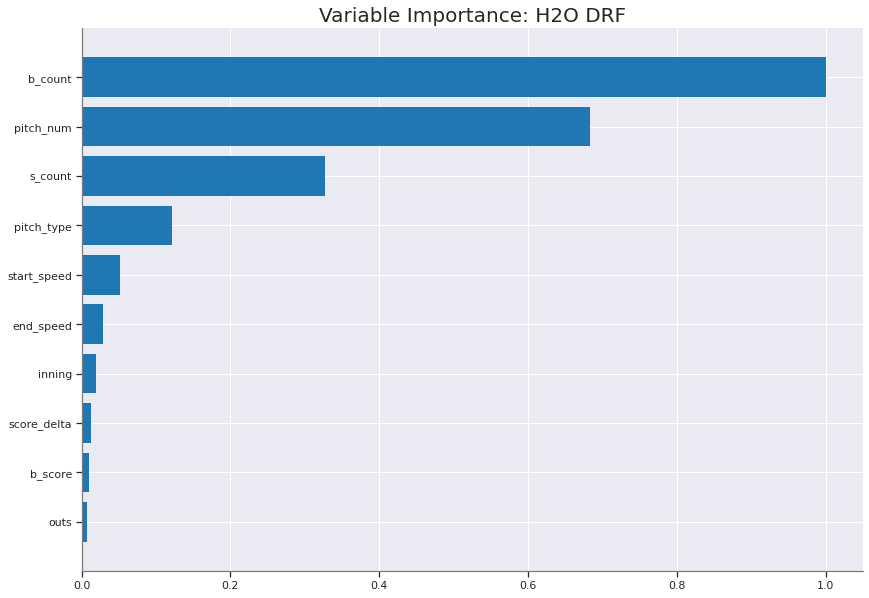

In [ ]:
# Variable Importance plot
model.varimp_plot()